In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import laplace, gaussian_kde
import scipy.cluster.hierarchy as hierarchy
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches

In [4]:
#df = pd.read_csv("/Users/albert/git/RTLib/Alignments/FP17_20180520_2/ev_combined.txt", sep="\t", low_memory=False)
df = pd.read_csv("/Users/albert/git/RTLib/Alignments/SQC87_95_20180611_2/ev_updated.txt", sep="\t", low_memory=False)

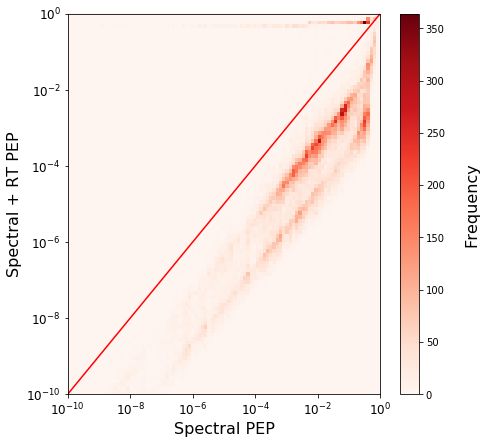

In [5]:
# PEP vs. PEP.new scatterplot
inds = (~pd.isnull(df["pep_new"])) & (df["pep_new"] > 1e-10) & (df["PEP"] > 1e-10)

f, ax = plt.subplots()
hst = ax.hist2d(np.log10(df["PEP"][inds]), np.log10(df["pep_new"][inds]), bins=(100, 100), cmap=plt.cm.Reds)
ax.plot([-10, 0], [-10, 0], '-r')

interval = (-10, 0)
ax.set_xlim(interval)
ax.set_ylim(interval)
ax.set_xlabel("Spectral PEP", fontsize=16)
ax.set_ylabel("Spectral + RT PEP", fontsize=16)
interval = np.arange(-10, 1, 2)
ax.set_xticks(interval)
ax.set_yticks(interval)
ax.set_xticklabels(["$10^{{{}}}$".format(i) for i in interval], fontsize=12)
ax.set_yticklabels(["$10^{{{}}}$".format(i) for i in interval], fontsize=12)

f.set_size_inches(7, 7)

cbar = plt.colorbar(hst[3], ax=ax)
cbar.set_label("Frequency", fontsize=16, labelpad=20, ha="center", va="top")
cbar.ax.xaxis.set_label_position("top")

plt.show()

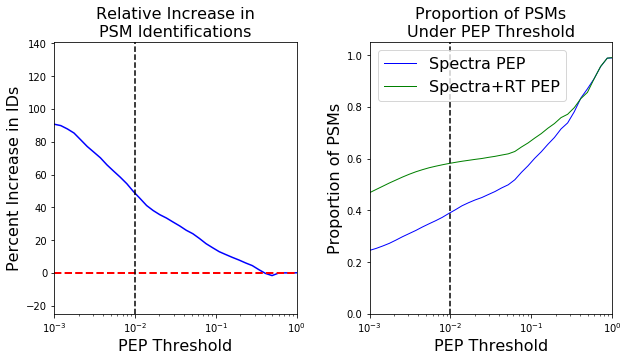

In [6]:
# Fold-change increase
num_points=50
x = np.logspace(-3, 1, num=num_points)
y = np.zeros(num_points)
y2 = np.zeros(num_points)
y3 = np.zeros(num_points)
inds = ~pd.isnull(df["pep_new"])

for i, j in enumerate(x):
    y[i] = np.sum(df["pep_updated"] < j) / np.sum(df["PEP"] < j)
    y2[i] = np.sum(df["PEP"] < j) / df.shape[0]
    y3[i] = np.sum(df["pep_updated"] < j) / df.shape[0]

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.semilogx(x, (y*100)-100, "-b")
ax1.plot([np.min(x), np.max(x)], [0, 0], "-r", linestyle="dashed", linewidth=2)
ax1.plot([1e-2, 1e-2], [-1000, 1000], '-k', linestyle="dashed")
ax1.set_xlim([1e-3, 1])
ax1.set_ylim([-25, np.max(y)*100-50])
ax1.set_xlabel("PEP Threshold", fontsize=16)
ax1.set_ylabel("Percent Increase in IDs", fontsize=16)
ax1.set_title("Relative Increase in\nPSM Identifications", fontsize=16)

ax2.semilogx(x, y2, '-b', linewidth=1, label="Spectra PEP")
ax2.semilogx(x, y3, '-g', linewidth=1, label="Spectra+RT PEP")
#ax2.fill_between(x, 0, y2)
ax2.plot([1e-2, 1e-2], [-1000, 1000], '-k', linestyle="dashed")
ax2.set_xlim([1e-3, 1])
ax2.set_ylim([0, 1.05])
ax2.set_xlabel("PEP Threshold", fontsize=16)
ax2.set_ylabel("Proportion of PSMs", fontsize=16)
ax2.set_title("Proportion of PSMs\nUnder PEP Threshold", fontsize=16)
ax2.legend(fontsize=16)
plt.subplots_adjust(hspace=0.6, wspace=0.3)

f.set_size_inches(10, 5)

plt.show()

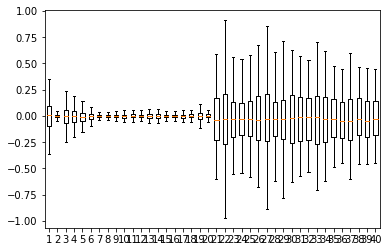

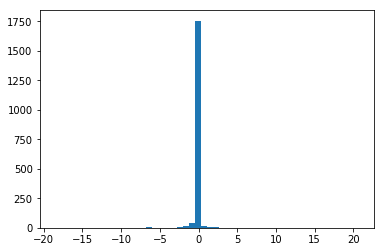

In [7]:
#residual = df["muij"] - df["Retention time"]
#plt.hist(residual[~pd.isnull(residual)], bins=50)
#plt.show()


residual = df["muij"] - df["Retention time"]

sds = df.groupby("exp_id")["residual"].apply((lambda x: np.nanstd(x)))

outliers = np.abs(residual) > (sds.values[df["exp_id"]] * 1)

#residual = np.log(np.abs(residual))

res = [residual[(df["exp_id"]==i) & (~pd.isnull(df["residual"])) & (~outliers)].values for i in range(0, np.max(df["exp_id"]))]
f, ax = plt.subplots()
#ax.violinplot(res)
ax.boxplot(res, showfliers=False)
plt.show()

np.nanstd(np.abs(residual.loc[df["exp_id"]==0]))

plt.hist(residual[(df["exp_id"]==10) & (~pd.isnull(residual))], bins=50)
plt.show()


In [8]:
prots = df["Leading razor protein"]
prots = prots.loc[(~prots.str.contains("REV__")) & (~prots.str.contains("CON__"))]
prots.reset_index(drop=True)

prot_list = prots.value_counts()
prot_list = prot_list.loc[prot_list > 50]

pep_thresh = 0.05

cvs = np.zeros((len(prot_list), 3))
n_cvs = np.zeros((len(prot_list), 3))

for i, j in enumerate(prot_list):
    prot_name = prot_list.index[i]
    intensities = df["Intensity"][(df["Leading razor protein"] == prot_name) & 
                                  (~pd.isnull(df["Intensity"])) & 
                                  (df["PEP"] < pep_thresh)]
    cvs[i][0] = np.std(intensities) / np.mean(intensities)
    n_cvs[i][0] = len(intensities)
    
    intensities = df["Intensity"][(df["Leading razor protein"] == prot_name) & 
                                  (~pd.isnull(df["Intensity"])) & 
                                  (df["pep_new"] < pep_thresh) &
                                  (df["PEP"] > pep_thresh)]
    cvs[i][1] = np.std(intensities) / np.mean(intensities)
    n_cvs[i][1] = len(intensities)
    
    dfa = df.loc[(~pd.isnull(df["Intensity"])) & 
                 (df["PEP"] < pep_thresh) &
                 (~df["Leading razor protein"].str.contains("REV__")) & 
                 (~df["Leading razor protein"].str.contains("CON__"))
                ].sample(n=j)
    cvs[i][2] = np.std(dfa["Intensity"]) / np.mean(dfa["Intensity"])
    n_cvs[i][2] = dfa.shape[0]

# remove pairs which have NAs in them
na_rows = np.apply_along_axis((lambda x: np.isnan(x).any()), 1, cvs)
na_rows = na_rows | (np.apply_along_axis((lambda x: (x == 1).any()), 1, n_cvs))
cvs = cvs[~na_rows]
n_cvs = n_cvs[~na_rows]


In [9]:
n_cvs

array([[1283.,   58., 1366.],
       [ 972.,  155., 1180.],
       [ 973.,   51., 1061.],
       [ 795.,   46.,  876.],
       [ 742.,   60.,  842.],
       [ 649.,   92.,  838.],
       [ 695.,   21.,  799.],
       [ 606.,   32.,  660.],
       [ 572.,   35.,  633.],
       [ 503.,   54.,  576.],
       [ 452.,   59.,  561.],
       [ 436.,   59.,  509.],
       [ 463.,   32.,  502.],
       [ 416.,   61.,  483.],
       [ 450.,   24.,  482.],
       [ 431.,   18.,  478.],
       [ 357.,   50.,  465.],
       [ 386.,   30.,  458.],
       [ 394.,   44.,  455.],
       [ 439.,    4.,  447.],
       [ 302.,   43.,  446.],
       [ 356.,   40.,  444.],
       [ 342.,   63.,  420.],
       [ 390.,   14.,  415.],
       [ 360.,   42.,  410.],
       [ 354.,   46.,  408.],
       [ 370.,   25.,  404.],
       [ 316.,   19.,  400.],
       [ 365.,   27.,  399.],
       [ 337.,   13.,  367.],
       [ 332.,   22.,  362.],
       [ 302.,   29.,  361.],
       [ 326.,   26.,  360.],
       [ 2

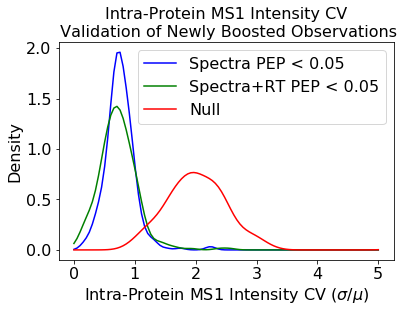

In [10]:
#plt.plot(cvs, null_cvs, '.k')
#plt.plot([0, 10], [0, 10], '-r')
#plt.show()

x = np.linspace(0, 5, 100)
cvs_density = gaussian_kde(cvs[:,0])
new_cvs_density = gaussian_kde(cvs[:,1])
null_cvs_density = gaussian_kde(cvs[:,2])

f, ax = plt.subplots()

ax.plot(x, cvs_density(x), '-b', label="Spectra PEP < {}".format(pep_thresh))
ax.plot(x, new_cvs_density(x), '-g', label="Spectra+RT PEP < {}".format(pep_thresh))
ax.plot(x, null_cvs_density(x), '-r', label="Null")
ax.set_xlabel("Intra-Protein MS1 Intensity CV ($\sigma$/$\mu$)", fontsize=16)
ax.set_ylabel("Density", fontsize=16)
ax.set_title("Intra-Protein MS1 Intensity CV\n Validation of Newly Boosted Observations", fontsize=16)
ax.tick_params(labelsize=16)
ax.legend(fontsize=16)

plt.show()

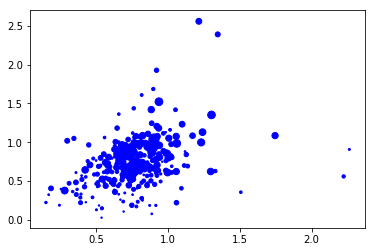

In [11]:
f, ax = plt.subplots()
ax.scatter(cvs[:,0], cvs[:,1], marker="o", color="b", s=n_cvs[:,1])

plt.show()

In [12]:
pep_thresh = 0.5
dcols = df.columns[df.columns.str.contains("Reporter intensity corrected")]
dfa = df.loc[~((df["Leading razor protein"].str.contains("CON__")) | (df["Leading razor protein"].str.contains("REV__")))]
dfa = dfa.loc[dfa["PEP"] < pep_thresh]

prot_dat = dfa.groupby("Leading razor protein")[dcols].apply((lambda x: (x != 0).apply(np.sum, axis=0) / x.shape[0]))
prot_dat

,Reporter intensity corrected 0,Reporter intensity corrected 1,Reporter intensity corrected 2,Reporter intensity corrected 3,Reporter intensity corrected 4,Reporter intensity corrected 5,Reporter intensity corrected 6,Reporter intensity corrected 7,Reporter intensity corrected 8,Reporter intensity corrected 9,Reporter intensity corrected 10
Leading razor protein,,,,,,,,,,,
1083132,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.950000,0.100000
1181996,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2136865,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0A075B6S5,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
A0A087X1C5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0A096LP49,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0A096LPI5,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A0A1B0GTR0,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
A0AVK6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


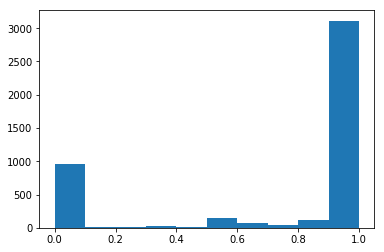

In [13]:
plt.hist(prot_dat.values[:,1])
plt.show()

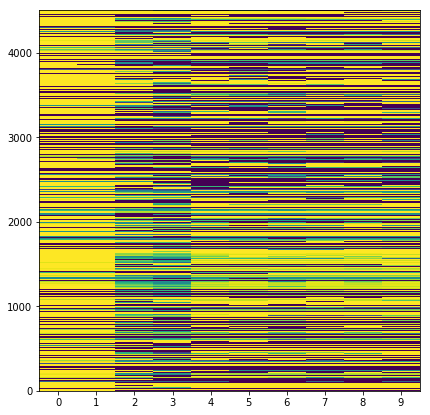

In [14]:
f, ax = plt.subplots()
ax.imshow(prot_dat.values, interpolation="nearest", aspect=10/prot_dat.shape[0], vmin=0)
ax.set_xticks(np.arange(0, 10, 1))
ax.set_xlim([-0.5, 9.5])
ax.set_ylim([0, prot_dat.shape[0]])

f.set_size_inches(7, 7)

plt.show()

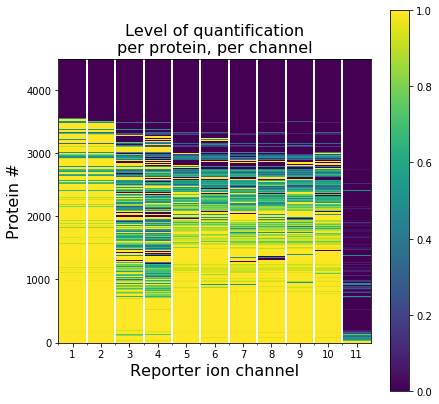

In [15]:
order = np.argsort(prot_dat.apply(np.sum, axis=1).values)[::-1]

#clust = hierarchy.fclusterdata(prot_dat, t=1.15)
#print(np.max(clust))
#order = np.argsort(clust)[::-1]

f, ax = plt.subplots()
mp = ax.imshow(prot_dat.values[order], interpolation="nearest", aspect=10/prot_dat.shape[0], vmin=0)
ax.set_xticks(np.arange(0, prot_dat.shape[1], 1))
ax.set_xticklabels(np.arange(1, prot_dat.shape[1]+1, 1))
ax.set_xlim([-0.5, prot_dat.shape[1]-0.5])
ax.set_ylim([0, prot_dat.shape[0]])

ax.set_xlabel("Reporter ion channel", fontsize=16)
ax.set_ylabel("Protein #", fontsize=16)
ax.set_title("Level of quantification\nper protein, per channel", fontsize=16)

ax.set_xticks(np.arange(-0.5, prot_dat.shape[1]-0.5, 1), minor=True);
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)

plt.colorbar(mp, ax=ax)

f.set_size_inches(7, 7)
plt.show()

In [16]:
pep_thresh = 0.01
dcols = df.columns[df.columns.str.contains("Reporter intensity corrected")]
dfa = df.loc[~((df["Leading razor protein"].str.contains("CON__")) | (df["Leading razor protein"].str.contains("REV__")))]
dfa = dfa.loc[((dfa[dcols] != 0).apply(np.sum, axis=1) / len(dcols)) > 0.8]

dfa["Leading razor protein"] = dfa["Leading razor protein"].str.split("|").apply((lambda x: x[1] if len(x) == 3 else x[0]))

dfa_new = dfa.loc[dfa["pep_updated"] < pep_thresh]
dfa = dfa.loc[dfa["PEP"] < pep_thresh]

print(dfa.shape[0])
print(dfa_new.shape[0])

31311
47497


In [17]:
prots = pd.Series(np.sort(dfa_new["Leading razor protein"].unique()))
print(len(prots))

experiments = np.sort(dfa["Raw file"].unique())

dmat = np.zeros((len(prots), len(experiments)))
dmat_new = np.zeros((len(prots), len(experiments)))

for i, exp in enumerate(experiments):
    dfe = dfa.loc[dfa["Raw file"]==exp]
    dmat[prots.isin(dfe["Leading razor protein"]), i] = 1
    dfe = dfa_new.loc[dfa_new["Raw file"]==exp]
    dmat_new[prots.isin(dfe["Leading razor protein"]), i] = 1
    
dmat
dmat_new

experiments

1224


array(['180508S_QC_SQC87A1', '180508S_QC_SQC87A10', '180508S_QC_SQC87A2',
       '180508S_QC_SQC87A3', '180508S_QC_SQC87A4', '180508S_QC_SQC87A5',
       '180508S_QC_SQC87A6', '180508S_QC_SQC87A7', '180508S_QC_SQC87A8',
       '180508S_QC_SQC87A9', '180508S_QC_SQC87C1', '180508S_QC_SQC87C10',
       '180508S_QC_SQC87C2', '180508S_QC_SQC87C3', '180508S_QC_SQC87C4',
       '180508S_QC_SQC87C5', '180508S_QC_SQC87C6', '180508S_QC_SQC87C7',
       '180508S_QC_SQC87C8', '180508S_QC_SQC87C9', '180514S_QC_SQC95A',
       '180524S_X_SQC95A10', '180524S_X_SQC95A11', '180524S_X_SQC95A12',
       '180524S_X_SQC95A13', '180524S_X_SQC95A14', '180524S_X_SQC95A15',
       '180524S_X_SQC95A16', '180524S_X_SQC95A17', '180524S_X_SQC95A18',
       '180524S_X_SQC95A19', '180524S_X_SQC95A20', '180524S_X_SQC95A21',
       '180524S_X_SQC95A22', '180524S_X_SQC95A3', '180524S_X_SQC95A4',
       '180524S_X_SQC95A5', '180524S_X_SQC95A6', '180524S_X_SQC95A7',
       '180524S_X_SQC95A8', '180524S_X_SQC95A9'], dtype

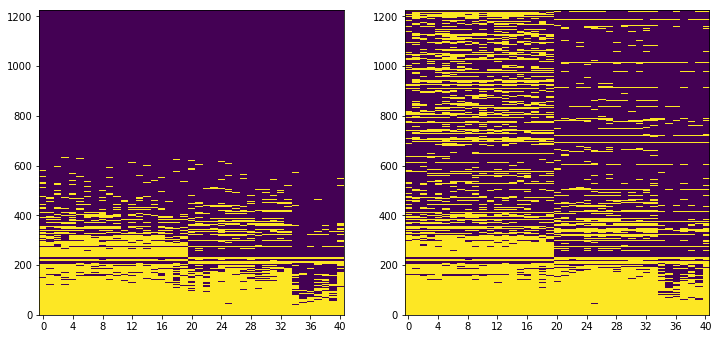

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2)

order = np.argsort(np.apply_along_axis(np.sum, 1, dmat))[::-1]

mp1 = ax1.imshow(dmat[order], interpolation="nearest", aspect = dmat.shape[1] / dmat.shape[0], vmin=0)
ax1.set_xticks(np.arange(0, dmat.shape[1], np.floor(dmat.shape[1] / 10)))
#ax1.set_xticklabels(experiments, rotation=45, ha="right", rotation_mode="anchor")
#ax1.set_xticks(np.arange(0, dmat.shape[1], 1))
ax1.set_ylim([0, dmat.shape[0]])

mp2 = ax2.imshow(dmat_new[order], interpolation="nearest", aspect = dmat.shape[1] / dmat.shape[0], vmin=0)
ax2.set_xticks(np.arange(0, dmat.shape[1], np.floor(dmat.shape[1] / 10)))
ax2.set_ylim([0, dmat.shape[0]])

f.set_size_inches(12, 7)

plt.show()

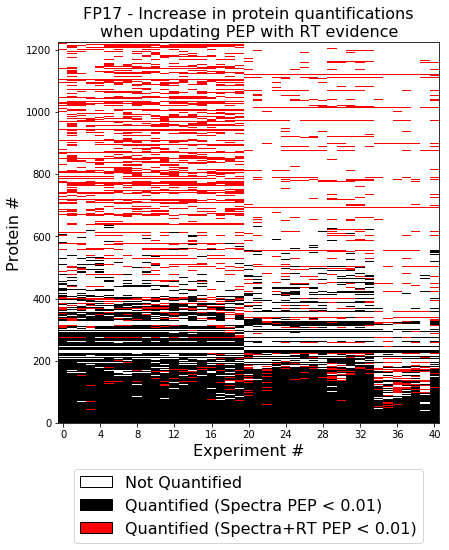

In [19]:
dmat_c = np.copy(dmat)
dmat_c[np.logical_and(np.logical_not(dmat), dmat_new)] = 2
#dmat_c

# Create the colormap
cm = LinearSegmentedColormap.from_list("a1", [(1, 1, 1), (0, 0, 0), (1, 0, 0)], N=3)

f, ax = plt.subplots()

#order = np.argsort(np.apply_along_axis(np.sum, 1, dmat_new))[::-1]
order = np.argsort(np.apply_along_axis(np.sum, 1, dmat))[::-1]

mp = ax.imshow(dmat_c[order], interpolation="nearest", aspect = dmat.shape[1] / dmat.shape[0], vmin=0, cmap=cm)
ax.set_xticks(np.arange(0, dmat.shape[1], np.floor(dmat.shape[1] / 10)))
#ax.set_xticklabels(experiments, rotation=45, ha="right", rotation_mode="anchor")
ax.set_ylim([0, dmat.shape[0]])

ax.set_xlabel("Experiment #", fontsize=16)
ax.set_ylabel("Protein #", fontsize=16)
ax.set_title("FP17 - Increase in protein quantifications\nwhen updating PEP with RT evidence", fontsize=16)

ax.legend(handles=[mpatches.Patch(facecolor='white', edgecolor='black', label='Not Quantified'),
                   mpatches.Patch(facecolor='black', edgecolor='black', label='Quantified (Spectra PEP < 0.01)'),
                   mpatches.Patch(facecolor='red',   edgecolor='black', label='Quantified (Spectra+RT PEP < 0.01)')],
         loc="upper center",
         fancybox=True, #shadow=True,
         bbox_to_anchor=(0.5, -0.1),
         fontsize=16)

f.set_size_inches(7, 7)

plt.show()

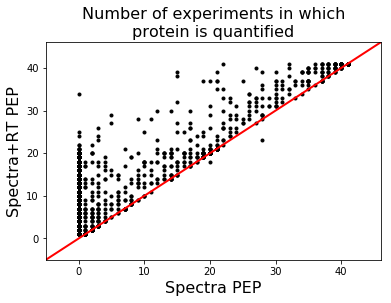

In [20]:
x = np.apply_along_axis(np.sum, 1, dmat)
y = np.apply_along_axis(np.sum, 1, dmat_new)

f, ax = plt.subplots()

ax.plot(x, y, '.k')
ax.plot([-100, 1000], [-100, 1000], '-r', linewidth=2)
ax.set_xlim([-5, dmat.shape[1]+5])
ax.set_ylim([-5, dmat.shape[1]+5])
ax.set_title("Number of experiments in which\nprotein is quantified", fontsize=16)
ax.set_xlabel("Spectra PEP", fontsize=16)
ax.set_ylabel("Spectra+RT PEP", fontsize=16)

plt.show()

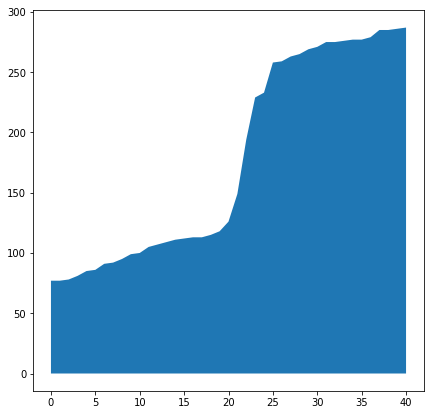

In [21]:
num = np.apply_along_axis(np.sum, 0, dmat)
num_new = np.apply_along_axis(np.sum, 0, dmat_new)
diff = np.apply_along_axis(np.sum, 0, dmat_new) - np.apply_along_axis(np.sum, 0, dmat)
np.argsort(diff)

x = np.arange(0, dmat.shape[1], 1)

f, ax = plt.subplots()

#ax.bar(x, np.sort(diff), color="red", width=0.8)
#ax.bar(x+0.3, num, color="blue", width=0.2)
#ax.bar(x+0.6, num_new, color="green", width=0.2)

#ax.plot(x, np.sort(diff), '-r')
ax.fill_between(x, np.sort(diff), 0)
#ax.plot(x, num, '-b')
#ax.plot(x, num_new, '-g')

#ax.set_xticks(x)
#ax.set_xticklabels(np.argsort(diff))
#ax.set_ylim([np.min(diff), np.max(num_new)])

f.set_size_inches(7, 7)

plt.show()

In [47]:
df['Protein'] = df['Leading razor protein'].str.split("|").apply((lambda x: x[1] if len(x) == 3 else x[0]))
df['Protein']

0              P36578
1              P36578
2              P36578
3              P36578
4              P36578
5              P36578
6              P36578
7              P36578
8              Q969F1
9              Q969F1
10             Q969F1
11             Q96T23
12        REV__Q15149
13        REV__Q15149
14        REV__Q15149
15             Q8IX94
16             Q8IX94
17             P54296
18             P54296
19             P54296
20             P54296
21             P54296
22             P54296
23             P54296
24             P54296
25             P54296
26             P54296
27             P54296
28             P54296
29             P54296
             ...     
117106         P07900
117107    REV__P22083
117108    REV__Q9Y5X2
117109         Q5VTE0
117110         Q5VTE0
117111         Q5VTE0
117112         Q5VTE0
117113         Q5VTE0
117114         Q5VTE0
117115         Q5VTE0
117116         Q5VTE0
117117         Q5VTE0
117118         Q5VTE0
117119         Q5VTE0
117120    

In [63]:
# remove rows w/o quant
quant_rows = ((df['Raw file'].str.contains('SQC')) & 
              (df[dcols[4:10]].apply((lambda x: x==0)).apply(np.sum, 1) == 0) &
              (~df['Protein'].str.contains('REV|CON')))
dmat = df.loc[quant_rows, dcols[4:10]].values
prots = df['Protein'].loc[quant_rows]
dmat

array([[1443.6 , 1192.7 , 1093.1 ,  904.92, 1892.7 , 1163.3 ],
       [1530.2 ,  877.37, 1342.4 , 1237.6 , 1638.1 ,  848.2 ],
       [2011.5 , 2024.2 , 1767.  , 1768.8 , 3051.7 , 1727.5 ],
       ...,
       [1187.5 ,  988.75,  493.19,  849.89, 1036.  ,  759.27],
       [ 332.7 ,  758.85,  656.06,  287.21,  471.82,  982.85],
       [ 538.17,  356.09,  712.07,  633.98, 1021.1 ,  473.27]])

In [81]:
dmatn = dmat / np.apply_along_axis(np.mean, 0, dmat)
dmatn = (dmatn / np.apply_along_axis(np.mean, 1, dmatn)[:,None])
dmatn

array([[1.14831919, 0.97412642, 1.01637156, 0.77675   , 1.17792152,
        0.90651132],
       [1.23267359, 0.72568982, 1.26403384, 1.07580987, 1.03242647,
        0.66936641],
       [0.99383123, 1.02686742, 1.02048356, 0.9430325 , 1.17965026,
        0.83613502],
       ...,
       [1.35697298, 1.160092  , 0.65876225, 1.04798636, 0.92622428,
        0.84996213],
       [0.56700109, 1.32786947, 1.30692755, 0.5281849 , 0.62910953,
        1.64090746],
       [0.87679169, 0.5956691 , 1.35605246, 1.11457123, 1.30155955,
        0.75535598]])

In [87]:
j_channels = [0, 2, 4]
u_channels = [1, 3, 5]
ratio_mat = np.zeros((dmatn.shape[0], len(j_channels) * len(u_channels)))
for i, j in enumerate(j_channels):
    for k, u in enumerate(u_channels):
        ratio_mat[:,(i*3)+k] = dmatn[:,j] / dmatn[:,u]
ratio_mat

array([[1.17881947, 1.47836393, 1.26674556, ..., 1.20920807, 1.51647443,
        1.29940079],
       [1.69862325, 1.14580989, 1.8415528 , ..., 1.42268287, 0.95967373,
        1.54239359],
       [0.96782818, 1.05386742, 1.18860137, ..., 1.14878535, 1.25091155,
        1.41083704],
       ...,
       [1.16971152, 1.2948384 , 1.59650993, ..., 0.79840589, 0.8838133 ,
        1.08972418],
       [0.42700062, 1.07348978, 0.34554117, ..., 0.47377363, 1.19107822,
        0.38339123],
       [1.47194422, 0.78666277, 1.1607662 , ..., 2.18503788, 1.16776704,
        1.72310749]])

In [105]:
df_a = pd.DataFrame(ratio_mat)
df_a['Protein'] = prots.values
df_a.groupby('Protein')

In [115]:
prot_ratios = np.zeros((len(prots.unique()), len(j_channels) * len(u_channels)))
for i, p in enumerate(prots.unique()):
    p_inds = (prots == p)
    prot_ratios[i,:] = np.apply_along_axis(np.mean, 0, ratio_mat[p_inds,:])
prot_ratios

array([[1.02655829, 1.02895854, 1.03369613, ..., 0.94401038, 0.94148065,
        0.94848577],
       [1.58483904, 2.10287498, 0.87523033, ..., 1.74277294, 2.31243268,
        0.96244961],
       [1.19888279, 1.09693396, 1.24921409, ..., 1.48010073, 1.30216118,
        1.51876229],
       ...,
       [0.56318119, 0.5704541 , 0.82511466, ..., 0.5950769 , 0.60276172,
        0.87184495],
       [0.88428235, 0.76869792, 0.68706544, ..., 0.82928534, 0.72653819,
        0.65095119],
       [0.50811882, 0.58148023, 0.76800403, ..., 0.57137254, 0.72733715,
        0.83969128]])

In [126]:
# get de novo proteins
a = df.groupby('Protein')[['PEP', 'pep_new']].apply(lambda x: np.any(x['PEP'] < 0.01))

In [185]:
Proteins = df['Protein']
pep = df['PEP']
#pd.DataFrame([Proteins.values, pep.values])
df_a = pd.concat([Proteins, pep], axis=1)
df_a.columns = ['protein', 'pep']
#df_a
#df_a.groupby('protein')['pep'].apply(lambda x: np.any(x['pep'] < 0.01))
#np.sum((df_a.groupby('protein')['pep'].min() > 0.01).values)
prots = np.sort(Proteins.unique())[(df_a.groupby('protein')['pep'].min() < 0.01)]
prots[~pd.isnull(prots)]


array(['A6NHQ2', 'B0I1T2', 'CON__A2I7N1',
       'CON__ENSEMBL:ENSBTAP00000018229',
       'CON__ENSEMBL:ENSBTAP00000024146',
       'CON__ENSEMBL:ENSBTAP00000038329', 'CON__P00761', 'CON__P01045-1',
       'CON__P01966', 'CON__P02769', 'CON__P04264', 'CON__P06868',
       'CON__P12763', 'CON__P13717', 'CON__P28800', 'CON__P34955',
       'CON__P35527', 'CON__P35908', 'CON__Q01546', 'CON__Q0IIK2',
       'CON__Q2KJF1', 'CON__Q3SX09', 'CON__Q3SX14', 'CON__Q3SX28',
       'CON__Q3SZ57', 'CON__Q3SZH5', 'CON__Q3SZR3', 'CON__Q3T052',
       'CON__Q3ZBS7', 'CON__Q58D62', 'CON__Q9TRI1',
       'CON__REFSEQ:XP_001252647', 'O00264', 'O00299', 'O00303', 'O00479',
       'O00487', 'O00567', 'O14737', 'O14818', 'O14950', 'O14979',
       'O14980', 'O15066', 'O15327', 'O15355', 'O43175', 'O43313',
       'O43390', 'O43598', 'O43707', 'O43776', 'O43809', 'O43869',
       'O60234', 'O60506', 'O60506-3', 'O75083', 'O75347', 'O75367-2',
       'O75368', 'O75381', 'O75390', 'O75477', 'O75531', 'O75533',

In [194]:
np.apply_along_axis(np.sum, 1, df[dcols[4:10]].values == 0)
#df['Leading razor protein'].str.extract(r'([A-Z0-9-]+)', expand=False).unique()

array([0, 0, 0, ..., 6, 5, 5])

In [196]:
os.path.dirname('/gd/MS/test.txt')
os.path.basename('/gd/MS/test.txt')

'test.txt'